<a href="https://colab.research.google.com/github/Shashiawari/Detect-Gpt/blob/main/DetectGpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries

In [ ]:
pip install transformers datasets scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


**Load Dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("/content/AI_Human.csv") #20,000+

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'], data['generated'], test_size=0.2, random_state=42
)


In [ ]:
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [ ]:
data.describe()

,generated
count,21376.00000
mean,0.53794
std,0.49857
min,0.00000
25%,0.00000
50%,1.00000
75%,1.00000
max,1.00000


In [ ]:
import seaborn as sns

<Axes: xlabel='generated', ylabel='count'>

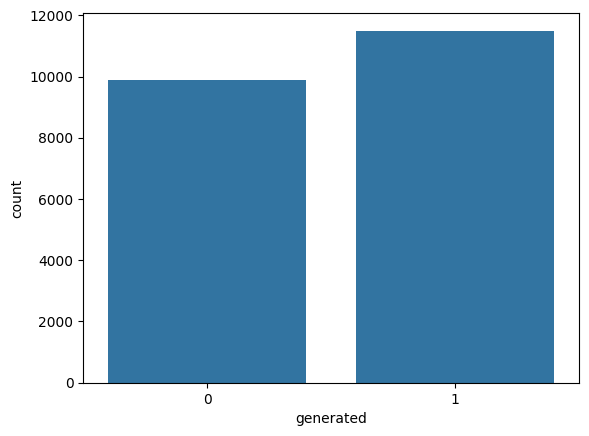

In [ ]:
sns.countplot(data=data,x='generated')

# **Preprocess The Data**

In [ ]:
# Drop rows with missing values
data = data.dropna(subset=['text', 'generated'])


In [ ]:
# Remove duplicates
data = data.drop_duplicates(subset=['text'])


In [ ]:
import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


data['text'] = data['text'].apply(clean_text)


In [ ]:

data = data[data['text'].str.len() > 10]


In [ ]:
data['text'][0]


'cars cars have been around since they became famous in the s when henry ford created and built the first modelt cars have played a major role in our every day lives since then but now people are starting to question if limiting car usage would be a good thing to me limiting the use of cars might be a good thing to do in like matter of this article in german suburb life goes on without cars by elizabeth rosenthal states how automobiles are the linchpin of suburbs where middle class families from either shanghai or chicago tend to make their homes experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe passenger cars are responsible for percent of greenhouse gas emissions in europeand up to percent in some carintensive areas in the united states cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go article paris bans driving due to smog by r

In [ ]:

data['generated'] = data['generated'].astype(int)


<ipython-input-14-bc24f6f3680f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['generated'] = data['generated'].astype(int)


Split Data into taining and validation sets

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'], data['generated'], test_size=0.2, random_state=42
)

Tokenize The data

In [ ]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Prepare Datasets

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


train_dataset = Dataset(train_encodings, list(train_labels))
val_dataset = Dataset(val_encodings, list(val_labels))


# Load Pre-trained Model

In [ ]:
from transformers import AutoModelForSequenceClassification


model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define Training **arguments**

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
      lr_scheduler_type="linear",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)




/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
pip uninstall wandb


Training

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.013300,0.086033
2,0.000000,0.030628
3,0.000200,0.037225


TrainOutput(global_step=3207, training_loss=0.006712237978811481, metrics={'train_runtime': 734.0091, 'train_samples_per_second': 69.886, 'train_steps_per_second': 4.369, 'total_flos': 1698795037214208.0, 'train_loss': 0.006712237978811481, 'epoch': 3.0})

Evaluation

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)


{'eval_loss': 0.037225302308797836, 'eval_runtime': 17.2291, 'eval_samples_per_second': 248.127, 'eval_steps_per_second': 15.555, 'epoch': 3.0}


# Prediction

In [ ]:

test_texts = ["""Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.

In like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article, "Paris bans driving due to smog," by Robert Duffer says, how Paris, after days of nearrecord pollution, enforced a partial driving ban to clear the air of the global city. It also says, how on Monday, motorist with evennumbered license plates were ordered to leave their cars at home or be fined a 22euro fine 31. The same order would be applied to oddnumbered plates the following day. Cars are the reason for polluting entire cities like Paris. This shows how bad cars can be because, of all the pollution that they can cause to an entire city.

Likewise, in the article, "Carfree day is spinning into a big hit in Bogota," by Andrew Selsky says, how programs that's set to spread to other countries, millions of Columbians hiked, biked, skated, or took the bus to work during a carfree day, leaving streets of this capital city eerily devoid of traffic jams. It was the third straight year cars have been banned with only buses and taxis permitted for the Day Without Cars in the capital city of 7 million. People like the idea of having carfree days because, it allows them to lesson the pollution that cars put out of their exhaust from people driving all the time. The article also tells how parks and sports centers have bustled throughout the city uneven, pitted sidewalks have been replaced by broad, smooth sidewalks rushhour restrictions have dramatically cut traffic and new restaurants and upscale shopping districts have cropped up. Having no cars has been good for the country of Columbia because, it has aloud them to repair things that have needed repairs for a long time, traffic jams have gone down, and restaurants and shopping districts have popped up, all due to the fact of having less cars around.

In conclusion, the use of less cars and having carfree days, have had a big impact on the environment of cities because, it is cutting down the air pollution that the cars have majorly polluted, it has aloud countries like Columbia to repair sidewalks, and cut down traffic jams. Limiting the use of cars would be a good thing for America. So we should limit the use of cars by maybe riding a bike, or maybe walking somewhere that isn't that far from you and doesn't need the use of a car to get you there. To me, limiting the use of cars might be a good thing to do.""", "Dear Senator "]
test_labels = [0, 1]


test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)
test_dataset = Dataset(test_encodings, test_labels)


prediction_output = trainer.predict(test_dataset)

logits = prediction_output.predictions
true_labels = prediction_output.label_ids

predicted_classes = np.argmax(logits, axis=1)

accuracy = np.mean(predicted_classes == true_labels)


print("Logits:\n", logits)
print("\nPredicted Classes:", predicted_classes)
print("\nTrue Labels:", true_labels)


Logits:
 [[ 5.205218  -4.8345532]
 [-1.4860564  1.6718311]]

Predicted Classes: [0 1]

True Labels: [0 1]


Training and Validation Loss Visualization

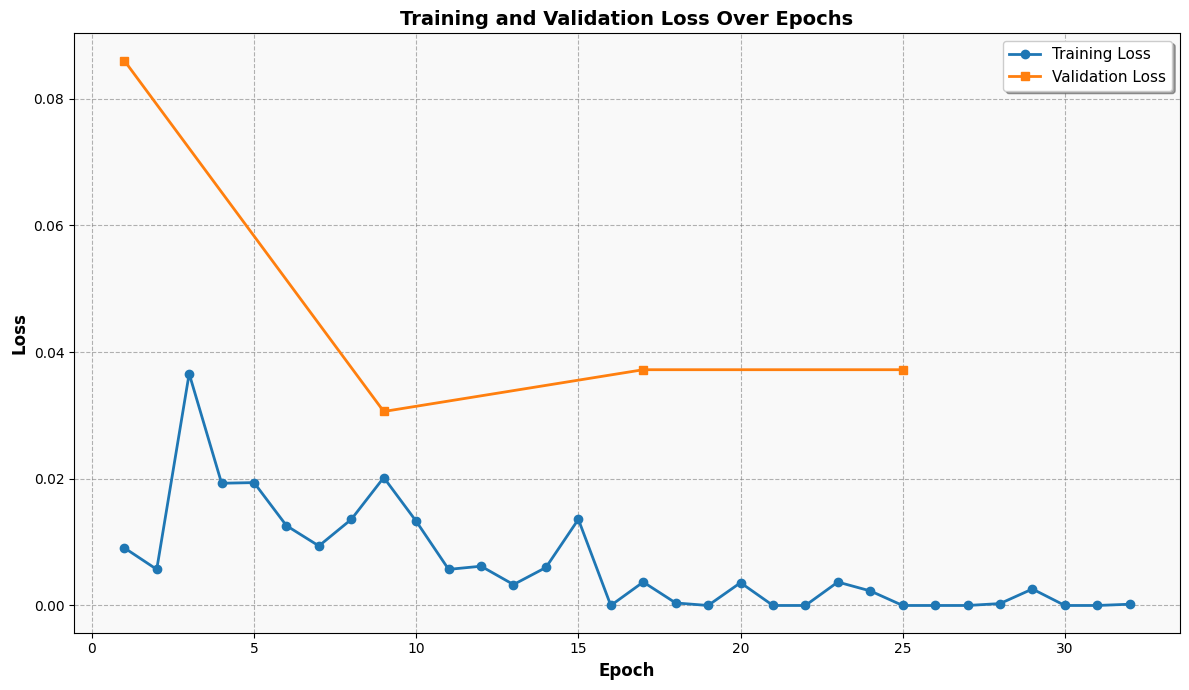

In [ ]:
import matplotlib.pyplot as plt

# Extract the training history
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Adjust epochs for eval_loss to match its length
eval_epochs = range(1, len(train_loss) + 1, int(len(train_loss) / len(eval_loss)))

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(
    range(1, len(train_loss) + 1),
    train_loss,
    label="Training Loss",
    marker="o",
    color="#1f77b4",
    linewidth=2,
)
plt.plot(
    eval_epochs,
    eval_loss,
    label="Validation Loss",
    marker="s",
    color="#ff7f0e",
    linewidth=2,
)


plt.grid(visible=True, linestyle="--", alpha=0.6, color="gray")
plt.gca().set_facecolor("#f9f9f9")


plt.xlabel("Epoch", fontsize=12, fontweight="bold")
plt.ylabel("Loss", fontsize=12, fontweight="bold")
plt.title("Training and Validation Loss Over Epochs", fontsize=14, fontweight="bold")


plt.legend(fontsize=11, loc="upper right", frameon=True, shadow=True, fancybox=True)

plt.tight_layout()
plt.show()


# Confusion Matrix

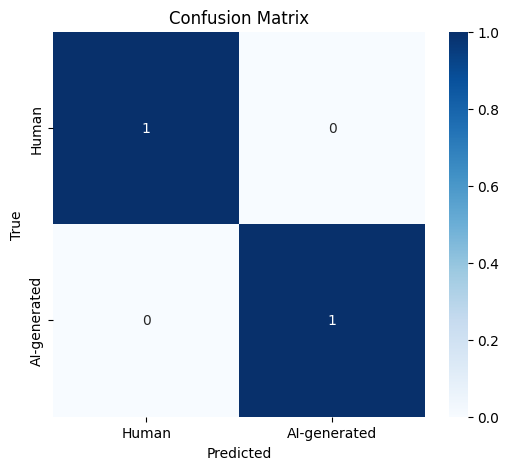

Confusion Matrix:
[[1 0]
 [0 1]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


logits = prediction_output.predictions
true_labels = prediction_output.label_ids


predicted_classes = np.argmax(logits, axis=1)


cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI-generated"], yticklabels=["Human", "AI-generated"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:")
print(cm)
